# Google Colab Lab Assignment 5.1 - Forecasting using LSTM

**Course Name:** PEC Deep Learning

**Lab Title:** To forecast future values of a univariate time series using LSTM-based models.

**Student Name:** Aryan Tamboli

**Student ID:** 202201040088

**Date of Submission:** 17/04/2025

**Group Members**:
1. Sahil Karne
2. Siddhesh Kotwal
3. Aryan Tamboli


**Objective**

To classify text sequences using LSTM-based models.
The task involves sentiment classification using the Twitter Sentiment Analysis dataset.




 # ✅ 1. Import Required Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# ✅ 2. Load and Inspect Dataset

In [5]:
# Load training and validation datasets
train_df = pd.read_csv('/content/twitter_training.csv', header=None)
valid_df = pd.read_csv('/content/twitter_validation.csv', header=None)

# Assign column names
train_df.columns = ['ID', 'Entity', 'Sentiment', 'Tweet']
valid_df.columns = ['ID', 'Entity', 'Sentiment', 'Tweet']

# Combine both datasets
df = pd.concat([train_df, valid_df], ignore_index=True)

# Show dataset info and sample
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         75682 non-null  int64 
 1   Entity     75682 non-null  object
 2   Sentiment  75682 non-null  object
 3   Tweet      74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None


,ID,Entity,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


# ✅ 3. Preprocess the Dataset

In [6]:
# Drop rows with missing values
df.dropna(subset=['Tweet', 'Sentiment'], inplace=True)

# Filter only valid sentiments
df = df[df['Sentiment'].isin(['Positive', 'Negative', 'Neutral'])]

# Encode sentiment labels into integers
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

# Extract features and labels
texts = df['Tweet'].values
labels = df['Sentiment'].values


# ✅ 4. Tokenization and Padding


In [7]:
# Tokenization parameters
vocab_size = 10000
max_length = 100
oov_token = "<OOV>"
padding_type = 'post'
trunc_type = 'post'

# Tokenize tweets
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


# ✅ 5. Split the Data



In [8]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 49559
Testing samples: 12390


# ✅ 6. Build the LSTM Model

In [9]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))  # 3 classes: Positive, Negative, Neutral

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# ✅ 7. Train the Model with Callbacks

In [10]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
mc = ModelCheckpoint('best_twitter_lstm.h5', save_best_only=True, monitor='val_loss', verbose=1)

history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=10,
                    batch_size=32,
                    callbacks=[es, mc],
                    verbose=1)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3555 - loss: 1.0969
Epoch 1: val_loss improved from inf to 1.09421, saving model to best_twitter_lstm.h5


1394/1394 ━━━━━━━━━━━━━━━━━━━━ 139s 96ms/step - accuracy: 0.3555 - loss: 1.0969 - val_accuracy: 0.3785 - val_loss: 1.0942
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3662 - loss: 1.0953
Epoch 2: val_loss improved from 1.09421 to 1.09376, saving model to best_twitter_lstm.h5


1394/1394 ━━━━━━━━━━━━━━━━━━━━ 138s 93ms/step - accuracy: 0.3662 - loss: 1.0953 - val_accuracy: 0.3785 - val_loss: 1.0938
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3611 - loss: 1.0959
Epoch 3: val_loss improved from 1.09376 to 1.09328, saving model to best_twitter_lstm.h5


1394/1394 ━━━━━━━━━━━━━━━━━━━━ 133s 95ms/step - accuracy: 0.3611 - loss: 1.0959 - val_accuracy: 0.3785 - val_loss: 1.0933
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3607 - loss: 1.0961
Epoch 4: val_loss improved from 1.09328 to 1.09312, saving model to best_twitter_lstm.h5


1394/1394 ━━━━━━━━━━━━━━━━━━━━ 142s 96ms/step - accuracy: 0.3607 - loss: 1.0961 - val_accuracy: 0.3785 - val_loss: 1.0931
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3608 - loss: 1.0957
Epoch 5: val_loss did not improve from 1.09312
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 130s 93ms/step - accuracy: 0.3608 - loss: 1.0957 - val_accuracy: 0.3785 - val_loss: 1.0933
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3639 - loss: 1.0950
Epoch 6: val_loss did not improve from 1.09312
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 145s 95ms/step - accuracy: 0.3639 - loss: 1.0950 - val_accuracy: 0.3785 - val_loss: 1.0937
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3611 - loss: 1.0961
Epoch 7: val_loss did not improve from 1.09312
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 139s 93ms/step - accuracy: 0.3611 - loss: 1.0961 - val_accuracy: 0.3785 - val_loss: 1.0935
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


# ✅ 8. Evaluate the Model

In [11]:
# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1:.4f}")


388/388 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step
Accuracy: 0.3646
Precision: 0.1330
F1-score: 0.1949


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# ✅ 9. Confusion Matrix

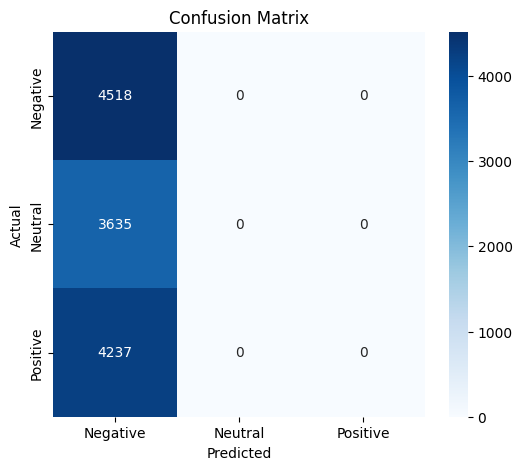


Classification Report:

              precision    recall  f1-score   support

    Negative       0.36      1.00      0.53      4518
     Neutral       0.00      0.00      0.00      3635
    Positive       0.00      0.00      0.00      4237

    accuracy                           0.36     12390
   macro avg       0.12      0.33      0.18     12390
weighted avg       0.13      0.36      0.19     12390



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


# ✅ 10. Accuracy & Loss Curves (Training vs Validation)

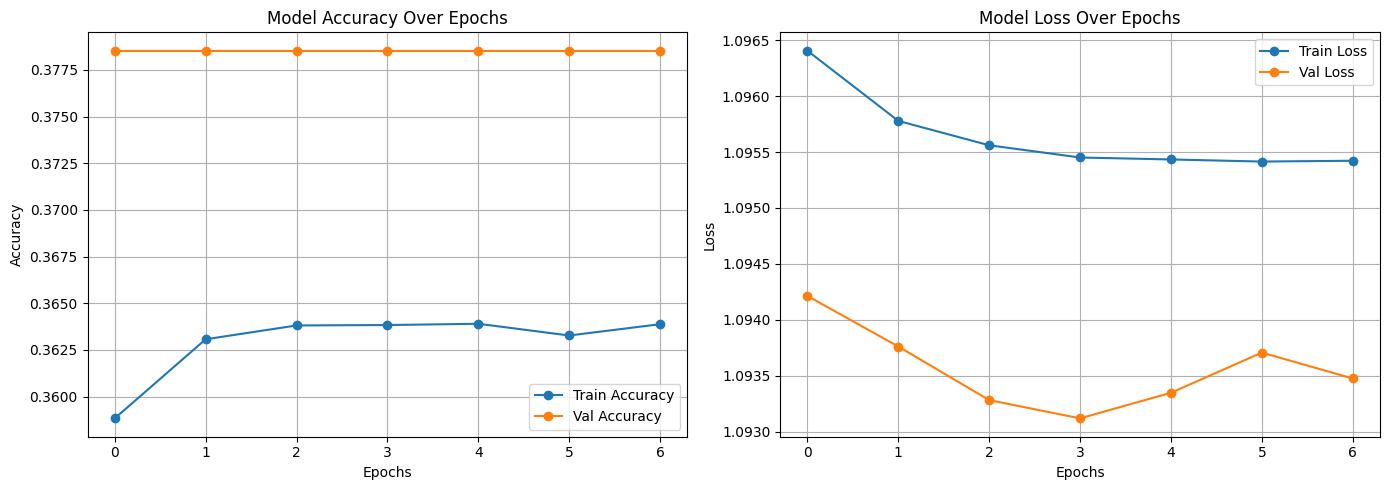

In [13]:
# Plot Accuracy and Loss over epochs
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# ✅ 11. Classification Report as a DataFrame (Pretty Table)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


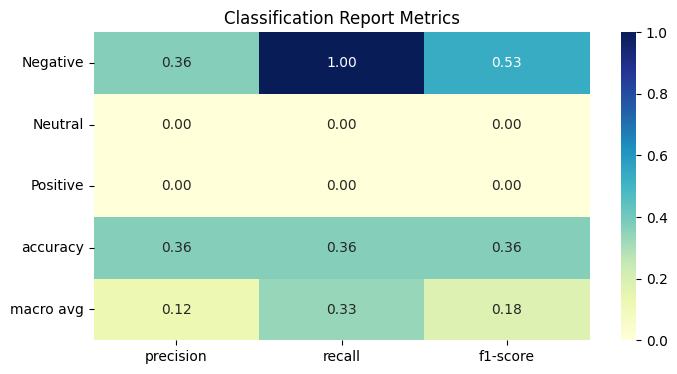

In [15]:
from sklearn.metrics import classification_report

# Get unique labels used in y_test
unique_labels = np.unique(y_test)

# Inverse transform numeric labels to their original string names
class_names = label_encoder.inverse_transform(unique_labels)

# Generate classification report
report_dict = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Plot as heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt='.2f', cmap='YlGnBu')
plt.title("Classification Report Metrics")
plt.show()


# ✅ 4. Bar Plot of Sentiment Distribution in Dataset

<ipython-input-16-22d8d52787cb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_labels, y=sentiment_counts.values, palette='pastel')


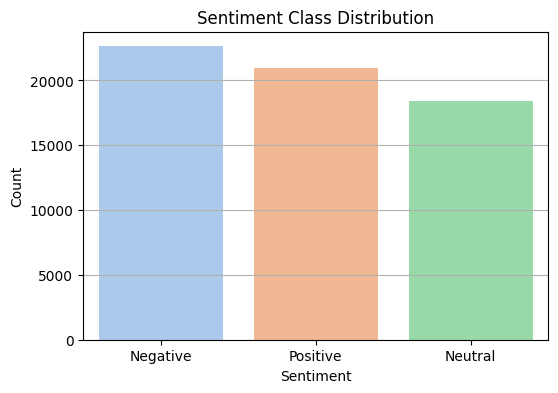

In [16]:
sentiment_counts = df['Sentiment'].value_counts()
sentiment_labels = label_encoder.inverse_transform(sentiment_counts.index)

plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_labels, y=sentiment_counts.values, palette='pastel')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(True, axis='y')
plt.show()


# ✅ 5. Word Cloud (Optional but Fancy)

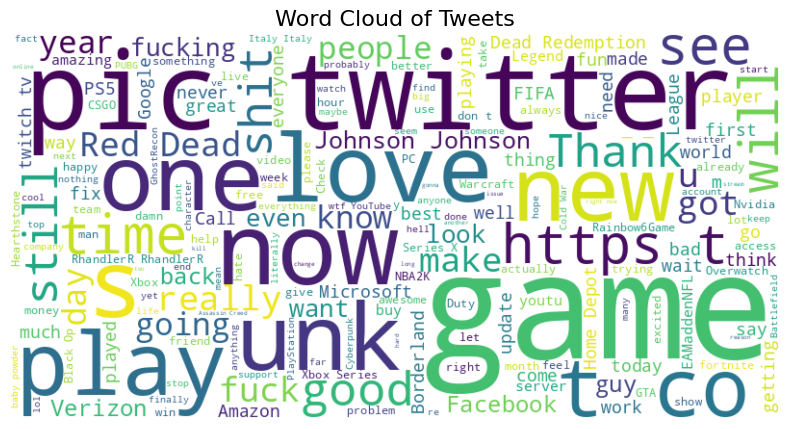

In [17]:
from wordcloud import WordCloud

# Combine all tweets into one string
all_text = ' '.join(df['Tweet'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tweets", fontsize=16)
plt.show()
